<a href="https://colab.research.google.com/github/ktgraze/ITAIMidtermGroup4/blob/main/ITAI_1378_Midterm_2024_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Computer Vision Midterm Assignment
## Introduction
Welcome to your Computer Vision midterm project! Here, you'll get hands-on experience building an image recognition model using Convolutional Neural Networks and transfer learning.


##Install Necessary Libraries:

In [ ]:
!pip install tensorflow
!pip install keras
!pip install numpy
!pip install matplotlib


In [ ]:
!pip install tensorflow-datasets==4.8.3
!pip install protobuf==3.20.3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.applications import VGG16, ResNet50, MobileNetV2  # Choose a pre-trained model
from keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds

**Dataset Selection and Loading**

* **Choose Your Dataset**
   * **Standard Datasets:** CIFAR-10, CIFAR-100, or a suitable subset of ImageNet are good starting points. You can use built-in functions to load them.
   * **Custom Dataset:** If you propose a custom dataset, ensure it has sufficient images per class, good quality, and accurate labeling. You'll need to upload it to Colab.
   * **Select your dataset and uncomment the appropriate loading code.**
   * **If you are using a custom dataset, make sure you have uploaded it to Colab and adjust the file path.**

# Load the Oxford IIIT Pet Dataset

In [ ]:
# Load the Oxford IIIT Pet dataset using TensorFlow- tfds.load()
(ds_train, ds_test), ds_info = tfds.load(
      'oxford_iiit_pet',
      split=['train', 'test'],
      shuffle_files=True,
      as_supervised=True,  # This will return (image, label) pairs
      with_info=True,
      try_gcs=True
  )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [5]:
# Extract the images and labels from both training and testing sets
x_train = []
y_train = []
for image, label in ds_train:
  # Resize the image to a consistent size
  image = tf.image.resize(image, [128, 128])
  x_train.append(image)
  y_train.append(label)

x_test = []
y_test = []
for image, label in ds_test:
  # Resize the image to a consistent size
  image = tf.image.resize(image, [128, 128])
  x_test.append(image)
  y_test.append(label)

# Convert the lists to tensors
x_train = tf.stack(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.stack(x_test)
y_test = tf.convert_to_tensor(y_test)

**Markdown Cell: Exploratory Data Analysis (EDA)**

* **Instructions:**
    * Visualize a few random images from your dataset to understand its content and overall quality.
    * Check the shape of your data to confirm the number of images and their dimensions.

Training data shape: (3680, 128, 128, 3)
Training labels shape: (3680,)
Test data shape: (3669, 128, 128, 3)
Test labels shape: (3669,)
Class Distribution (Top 10):
[(6, 100), (13, 100), (1, 100), (30, 100), (34, 100), (9, 100), (16, 100), (2, 100), (17, 100), (20, 100)]


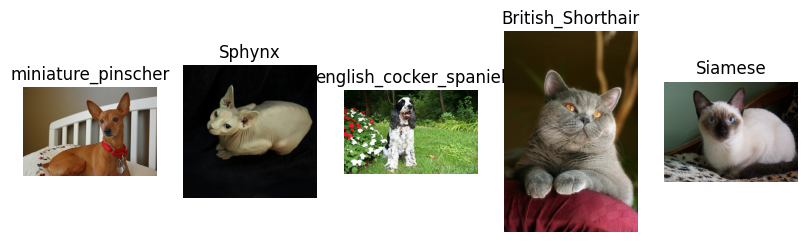

In [6]:
# Display sample images
def plot_images(dataset, num_images=5):
  plt.figure(figsize=(10, 5))
  for i, (image, label) in enumerate(dataset.take(num_images)):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.title(ds_info.features['label'].int2str(label))
    plt.axis('off')
plt.show()
plot_images(ds_train)

print('Training data shape:', x_train.shape)
print('Training labels shape:', y_train.shape)
print('Test data shape:', x_test.shape)
print('Test labels shape:', y_test.shape)

# Explore class distribution (if using a standard dataset)
from collections import Counter
print('Class Distribution (Top 10):')
print(Counter(y_train.numpy()).most_common(10))

**Image Preprocessing**

* **Instructions:**
    1. **Normalization:**
       * Normalize pixel values (usually to the range of 0-1 or -1 to 1)  
    2. **Resizing:**
       * Resize images to a consistent size for model input.

In [7]:
# Normalize the data
x_train = tf.cast(x_train, tf.float32) / 255.0 # Changed x_train.astype to tf.cast
x_test = tf.cast(x_test, tf.float32) / 255.0 # Changed x_test.astype to tf.cast


# Resize images if needed (adjust input_shape in model building accordingly)
x_train = tf.image.resize(x_train, (224, 224))  # Example for resizing to 224x224
x_test = tf.image.resize(x_test, (224, 224))


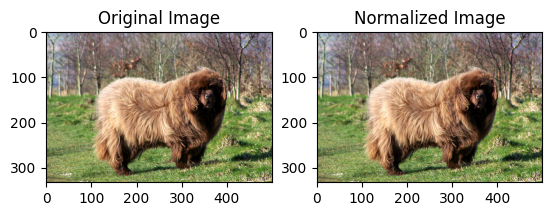

In [12]:
# Get a single image and label from ds_train
image, label = next(iter(ds_train))

# Original image
original_image = image.numpy()

# Normalize the image
normalized_image = tf.cast(image, tf.float32) / 255.0

# Display the images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(original_image)
axes[0].title.set_text('Original Image')
axes[1].imshow(normalized_image.numpy())
axes[1].title.set_text('Normalized Image')
plt.show()

# ** Data Augmentation **

* **Instructions:**

1. Experiment with Parameters:  The code below has some example data augmentation parameters. Try changing the values within these parameters, or even adding new augmentation techniques! Here's a short guide:

* Hint 1: Start with small adjustments to see the effects clearly.
* Hint 2: Consider which augmentations make sense for your dataset. Flipping images of letters might be okay, but rotating them too much could make them unreadable!

* Explore more: Try adding things like shear_range (for shearing transformations) or zoom_range (for random zooming).

2. Visualize the Effects: After setting up your ImageDataGenerator, add a few lines of code to display some randomly augmented images from your dataset. This will help you see how your chosen parameters change the images.
* Hint: Use a small sample of images so it's easy to compare the originals with the augmented versions.

In [19]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[.8, 1.2],
    channel_shift_range=20
)
datagen.fit(x_train) # Fit the augmentation parameters to the training data


#Model Building (Transfer Learning)

In [ ]:
# Choose a pre-trained model suitable for object recognition (VGG16, ResNet50, MobileNetV2 are all options)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])

# Freeze some layers of the pre-trained model (optional)
for layer in base_model.layers[:10]:
   layer.trainable = False  # Adjust the number of layers to freeze as needed

# Add custom top layers
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Adjust num_classes for your dataset

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Model Training




In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=15,  # Adjust as needed
                    validation_data=(x_test, y_test),
                    callbacks=[ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')])


#Enhanced Training

Implement data augmentation within the training loop.
Add callbacks to monitor progress and save the best performing model.
Modify the Training Code: If you haven't already, we need to make a few changes to your training loop:

1.   Integrate the Data Augmentation: Replace the
direct use of x_train with datagen.flow(x_train, y_train, batch_size=32). This will apply your augmentations in real-time during training
2.   Use the Validation Set: We already have validation_data=(x_test, y_test).
3. Save the Best Model: We're using a ModelCheckpoint callback to automatically save the model if its performance on the validation set improves
* Hint: Experiment with different batch sizes as well.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# Data Augmentation with ImageDataGenerator
datagen = ImageDataGenerator(
       rotation_range=20,
       width_shift_range=0.1,
       height_shift_range=0.1,
       horizontal_flip=True)

#  Modify the model fitting to use real-time augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=15,
                    validation_data=(x_test, y_test),  # Use the test set for validation
                    callbacks=[ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')])


#Visualizing Training Progress

Importance of Monitoring: Explain why tracking validation metrics helps identify overfitting or underfitting.

*   Plot training and validation accuracy/loss curves.


In [ ]:
# Plot training and validation curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Plot the loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


#Evaluation on the Test Set

Discuss how test set metrics provide the most unbiased assessment of model performance.

In [ ]:
best_model = load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


#Hyperparameter Tuning

>Exploring Learning Rates: In the provided code, we're iterating through different learning rates.
* Hint 1: A good starting range for the learning rate is often between 0.01 and 0.0001.
* Hint 2: Pay close attention to how quickly the validation loss starts to increase (if it does), which might signal a learning rate that's too high.



In [ ]:
def create_model(learning_rate=0.01):
    # ... (Code to build your model, using the learning_rate parameter)
    return model

# Basic parameter exploration
for lr in [0.01, 0.001, 0.0001]:
    model = create_model(learning_rate=lr)
    # ... (Training the model)


#Confusion Matrx

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#Discussion and Further Exploration

##Questions to consider:
1. How does the choice of pre-trained model (VGG16, ResNet50, etc.) affect the results?
2. Analyze the confusion matrix: Are errors more common between certain classes? What might explain this?
3. Experiment with different degrees of fine-tuning (freezing more/fewer layers of the pre-trained model).
4. If applicable to your dataset, can you collect more data for classes with higher error rates?
What are other ways to potentially improve accuracy? (e.g., ensembling models, exploring advanced augmentation strategies, class-weighted training)

Sources
towardsdatascience.com/build-your-own-deep-learning-classification-model-in-keras-511f647980d6
stackoverflow.com/questions/69997327/tensorflow-valueerror-input-0-is-incompatible-with-layer-model-expected-shape
www.influxdata.com/blog/time-series-forecasting-with-tensorflow-influxdb/